Author Yizhou Li, e-mail: lyzpp2000@163.com

Problem Statement:

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling<br>
or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences<br>
price negotiations than the number of bedrooms or a white-picket fence.<br>
<br>
With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition<br>
challenges you to predict the final price of each home.

# Data Preprocessing

In [29]:
# Load initial libraries.
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

# Functions.
def drop_duplicates(my_df):
    my_df.drop_duplicates(inplace=True)
    my_df = my_df.loc[:,~my_df.columns.duplicated()]
    return my_df

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

def drop_columns_missing_above_80_percent(train_df, test_df) -> None :
    null_series = train_df.isnull().sum().sort_values(ascending=False)
    print("columns have null values:\n", null_series, "\n", sep="")
    temp_lst = []
    for i,v in null_series.items():
        if v / train_df.shape[0] >= 0.8:
            temp_lst.append(i)
    train_df.drop(temp_lst, axis=1, inplace=True)
    null_series = train_df.isnull().sum().sort_values(ascending=False)
    print("after we drop the columns that miss 80 percent values:\n", null_series, sep="")

    null_series = test_df.isnull().sum().sort_values(ascending=False)
    print("columns have null values:\n", null_series, "\n", sep="")
    temp_lst = []
    for i,v in null_series.items():
        if v / test_df.shape[0] >= 0.8:
            temp_lst.append(i)
    test_df.drop(temp_lst, axis=1, inplace=True)
    null_series = test_df.isnull().sum().sort_values(ascending=False)
    print("after we drop the columns that miss 80 percent values:\n", null_series, sep="")

# Load Data.
train_df = pd.read_csv("input/train.csv")
test_df = pd.read_csv("input/test.csv")

# Concatenate dataframes, and take out y_train column
num_train = train_df.shape[0]
# num_test = test_df.shape[0]
all_df = pd.concat((train_df, test_df)).reset_index(drop=True)
print("train_df size is : {}".format(train_df.shape))
print("test_df size is : {}".format(test_df.shape))
print("all_df size is : {}".format(all_df.shape))

# Import libraries.
from numpy import mean, mean, std
from pandas import read_csv
from sklearn.model_selection import cross_val_score, KFold
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

# Get both numerical and categorical columns. 
numerical_ix = train_df.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = train_df.select_dtypes(include=['object', 'bool']).columns

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy="most_frequent")),('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, selector(dtype_include="number")),('cat', categorical_transformer, selector(dtype_include="object"))],remainder="passthrough")

# print("numerical_ix: ", numerical_ix, " categorical_ix: ", categorical_ix)
# print("Before processing: \n", train_df, "\n")
all_df.drop(['SalePrice'], axis=1, inplace=True)
all_ndarray = preprocessor.fit_transform(all_df)     # todo: be aware 1 column ndarray       
all_df = pd.DataFrame(data=all_ndarray)                                                                                                       
# print("After processing: \n", train_df)

# Extract SalePrice column to train models later.
y_train = train_df["SalePrice"]
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
y_train = pd.DataFrame(data=imp_mean.fit_transform(y_train.to_frame()))
print(y_train.info())





# # Creat train test splits.
# x_train = all_df[:num_train]
# predict_df = all_df[num_train:]
# print("x_train shape is : {}".format(x_train.shape))
# print("x_test shape is : {}".format(predict_df.shape))
# print("y_train shape is: {}".format(y_train.shape))

# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = .3, random_state=0)
# print("x_train shape is : {}".format(X_train.shape))
# print("x_test shape is : {}".format(X_test.shape))
# print("y_train shape is: {}".format(Y_train.shape))
# print("y_test shape is: {}".format(Y_test.shape))

# # importing all the required library for modeling here we are going to use statsmodels 
# import statsmodels.api as sm
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, BayesianRidge, LassoLarsIC
# from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
# from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
# # from mlxtend.regressor import StackingCVRegressor
# from xgboost import XGBRegressor
# # from lightgbm import LGBMRegressor
# from sklearn.kernel_ridge import KernelRidge
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import RobustScaler
# from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
# from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
# import xgboost as xgb
# # import lightgbm as lgb

# ## Call in the LinearRegression object
# lin_reg = LinearRegression(normalize=True, n_jobs=-1)
# ## fit train and test data. 
# lin_reg.fit(x_train, y_train)
# ## Predict test data. 
# y_train_pred = lin_reg.predict(X_train)
# y_test_pred = lin_reg.predict(X_test)
# print("y_train shape is : {}".format(y_train.shape))
# print("x_train shape is : {}".format(x_train.shape))

# ## get average squared error(MSE) by comparing predicted values with real values. 
# print ('RMSE for Train data %.4f'%np.sqrt(mean_squared_error(Y_train, y_train_pred)))
# print ('RMSE for Test data %.4f'%np.sqrt(mean_squared_error(Y_test, y_test_pred)))

# parity plot  
# plt.scatter(y_train_pred,Y_train,color='blue')
# plt.title('Linear Regression')
# plt.xlabel('Predicted Values')
# plt.ylabel('Actual Values')
# plt.plot([10.5,13.5],[10.5,13.5],c='red')
# plt.show()

# rgr = Pipeline(steps=[('preprocessor', preprocessor),
#                   ('regressor', LinearRegression())]).fit(X_train, y_train)

# rgr.predict(test_df)


train_df size is : (1460, 81)
test_df size is : (1459, 80)
all_df size is : (2919, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1460 non-null   float64
dtypes: float64(1)
memory usage: 11.5 KB
None


AttributeError: columns not found

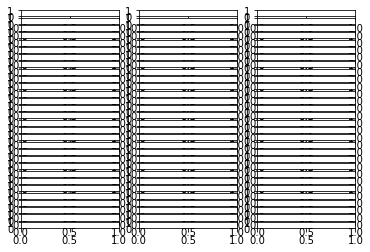

In [13]:
fig, axs = plt.subplots(30, 3)
my_lst = [col for col in train_df.columns]
fig.set_size_inches(25, 200)
row = 30
col = 3
y = train_df["SalePrice"]
for i in range(row):
    for j in range(col):
        if len(my_lst) == 0:
            break
        x = train_df[my_lst.pop()]
        axs[i, j].scatter(x, y)
        axs[i, j].set_xlabel(x.name)
        axs[i, j].set_ylabel("SalePrice")
        axs[i, j].set_title(x.name + " vs SalePrice")

# 5. Models building, evaluation, and predicting


In [ ]:
model = LinearRegression()
model2 = Lasso()
model3 = Ridge()
model4 = DecisionTreeRegressor()
model5 = RandomForestRegressor()

model.fit(X=x_train, y=y_train)
model2.fit(X=x_train, y=y_train)
model3.fit(X=x_train, y=y_train)
model4.fit(X=x_train, y=y_train)
model5.fit(X=x_train, y=y_train)

print("the accuracy score using with LinearRegression() model ", model.score(x_test, y_test))
print("the accuracy score using with Lasso() model ", model2.score(x_test, y_test))
print("the accuracy score using with Ridge() model ", model3.score(x_test, y_test))
print("the accuracy score using with DecisionTreeRegressor() model ", model4.score(x_test, y_test))
print("the accuracy score using with RandomForestRegressor() model ", model5.score(x_test, y_test))

model.fit(X=x_train, y=y_train)
result = model.predict(test_data)
temp = test_df
temp.reset_index(inplace=True)
metric = pd.Series(result, name = 'SalePrice')
final_metric = pd.concat([temp["Id"], metric], axis = 1)
final_metric.to_csv("submission.csv",index =False)

the accuracy score using with LinearRegression() model  0.699274404306837
the accuracy score using with Lasso() model  0.699255842859624
the accuracy score using with Ridge() model  0.6988298969020352
the accuracy score using with DecisionTreeRegressor() model  0.5258261751040558
the accuracy score using with RandomForestRegressor() model  0.647976119535729


ValueError: cannot insert level_0, already exists